In [1]:
# %% init
import os
os.chdir("/home/tangir/crmbm/python/shrimp")

from IPython import get_ipython
get_ipython().magic("clear")

import matplotlib.pylab as plt
import matplotlib.dates as mdates
import mrs.reco as reco
import mrs.sim as sim
import mrs.db as db
import mrs.log as log
import mrs.aliases as xxx
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import suspect
from datetime import datetime

plt.close("all")
plt.rcParams['figure.dpi'] = 75
plt.rcParams['figure.max_open_warning'] = 1000
plt.rcParams["figure.figsize"] = [8, 6]
# get_ipython().magic("matplotlib inline")
get_ipython().magic("matplotlib notebook")
log.setLevel(log.INFO)

cm = sns.color_palette("rocket", as_cmap=True)
pd.set_option('display.max_rows', 50)
pd.options.mode.chained_assignment = None  # default='warn'

(DEBUG) Loaded backend nbAgg version unknown.


# Load dataframes from files

In [2]:
df_sc = pd.read_pickle("/home/tangir/crmbm/acq_db/sc_notebook.pkl")
df_brain = pd.read_pickle("/home/tangir/crmbm/acq_db/brain_notebook.pkl")

Actually, when we really look at the scatter plots and recalculate the correlation coeff, there is not much than stays above 0.5... And what is left, we could definitely guessed: Vref & pulse durations, etc. 

# Prepare dataframes
Anything below deals with fit results

## Load fit data

In [ ]:
rdb_sc = db.data_db("/home/tangir/crmbm/acq_db/sc.pkl")
rdb_brain = db.data_db("/home/tangir/crmbm/acq_db/brain.pkl")
df_fit = rdb_sc.extend_df_fit()
df_brain_fit = rdb_brain.extend_df_fit()

# remove db objects to free memory
del(rdb_sc)
del(rdb_brain)


(INFO)  data_db.__init__: initializing db files [in progress]
(INFO)  data_db.__init__: /home/tangir/crmbm/acq_db/sc.pkl
(INFO)  data_db.__init__: /home/tangir/crmbm/acq_db/sc_fit.pkl
(INFO)  data_db.__init__: initializing db files [done]
(INFO)  data_db.__init__: initializing db files [in progress]
(INFO)  data_db.__init__: /home/tangir/crmbm/acq_db/brain.pkl
(INFO)  data_db.__init__: /home/tangir/crmbm/acq_db/brain_fit.pkl
(INFO)  data_db.__init__: initializing db files [done]
(INFO)  data_db.extend_df_fit: extending dataframe by scraping data...


## Join data

In [ ]:
# SC dataframe
df_sc = pd.merge(df_fit, df_sc, left_on='scan_hash', right_index=True, how='inner', sort=False)

# brain dataframe
df_brain = pd.merge(df_brain_fit, df_brain, left_on='scan_hash', right_index=True, how='inner', sort=False)

## Show really badly fitted SC datasets
using FQN and R2, just to check things and reco/refit if necessary

In [ ]:
df = df_sc

rsq_f_threshold = 0.6
fqn_threshold = 3

df_bad_fit = df.loc[(df["fit_results_optim_result_rsq_f"] < rsq_f_threshold)
                    & (df["fit_results_optim_result_fqn"] > fqn_threshold)]

k = 0
for this_index, this_row in df_bad_fit.iterrows():
    s = this_row["dataset_raw_data_obj"]
    if(s is None):
        s = this_row["dataset_dcm_data_obj"]
    
    s.set_display_offset(20000.0 * k)
    s.display_spectrum_1d(3303)
    k += 1
    
df_bad_fit[["patient", "study", "scan_hash", "fit_strategy_name", "dataset_legend", "dataset_raw_analysis-results_cropping_snr", "dataset_raw_analysis-results_cropping_lw"]]

Only three datasets are really badly fitted - whatever the fit strategy used. Let's see how they annoy us for the following... 

## Recalculate metabolite parameters
* T2/T1 normalization
* ratios
* absolute concentrations
* relative CRBs

In [ ]:
water_concentration = 55000.0

def add_metabolite_concentration_columns(this_df, water_c):
    # init new columns
    some_init_col = this_df["fit_results_params_ref_area_pnorm_obj"]
    
    this_df["params_area_pnorm_T2norm_obj"] = some_init_col
    this_df["params_ref_area_pnorm_T2norm_obj"] = some_init_col
    this_df["params_area_pnorm_T2norm_abs_obj"] = some_init_col
    this_df["params_area_pnorm_T2norm_ratio_cre_obj"] = some_init_col

    this_df["params_fit_obj"] = some_init_col
    this_df["params_fit_T2norm_obj"] = some_init_col
    this_df["params_ref_fit_T2norm_obj"] = some_init_col
    this_df["params_fit_T2norm_abs_obj"] = some_init_col
    this_df["params_fit_T2norm_ratio_cre_obj"] = some_init_col
    #
    this_df["params_fit_obj_with_err_prct"] = some_init_col
    this_df["params_fit_T2norm_abs_obj_with_err_prct"] = some_init_col
    this_df["params_fit_T2norm_ratio_cre_obj_with_err_prct"] = some_init_col

    for this_index, this_row in this_df.iterrows():
        # get params for this row
        p_area = this_row["fit_results_params_area_pnorm_obj"]
        p_ref_area = this_row["fit_results_params_ref_area_pnorm_obj"]
        p_fit = this_row["fit_results_params_fit_final_obj"]
        p_ref_fit = this_row["fit_results_params_ref_fit_obj"]

        # normalize T2
        this_te = this_row["dataset_raw_data__te"]
        p_area_T2norm = p_area.correct_T2s(this_te)
        p_ref_area_T2norm = p_ref_area.correct_T2s(this_te)
        #
        p_fit_T2norm = p_fit.correct_T2s(this_te)
        p_ref_fit_T2norm = p_ref_fit.correct_T2s(this_te)

        # relative to water
        p_area_T2norm_rel_water = p_area_T2norm.get_relative_to_meta(xxx.m_Water, water_c, p_ref_area_T2norm)
        #
        p_fit_T2norm_rel_water = p_fit_T2norm.get_relative_to_meta(xxx.m_Water, water_c, p_ref_fit_T2norm)

        # ratios relative to cr
        p_area_T2norm_ratio_cr = p_area_T2norm.get_ratios(xxx.m_Cr_CH3)
        #
        p_fit_T2norm_ratio_cr = p_fit_T2norm.get_ratios(xxx.m_Cr_CH3)
        
        # rel. CRBs in prct
        p_fit_err = p_fit.copy()
        p_fit_err._errors = (p_fit.errors / p_fit) * 100.0
        p_fit_T2norm_rel_water_err = p_fit_T2norm_rel_water.copy()
        p_fit_T2norm_rel_water_err._errors = (p_fit_T2norm_rel_water.errors / p_fit_T2norm_rel_water) * 100.0
        p_fit_T2norm_ratio_cr_err = p_fit_T2norm_ratio_cr.copy()
        p_fit_T2norm_ratio_cr_err._errors = (p_fit_T2norm_ratio_cr.errors / p_fit_T2norm_ratio_cr) * 100.0
        
        # store
        this_df.at[this_index, "params_area_pnorm_T2norm_obj"] = p_area_T2norm
        this_df.at[this_index, "params_ref_area_pnorm_T2norm_obj"] = p_ref_area_T2norm
        this_df.at[this_index, "params_area_pnorm_T2norm_abs_obj"] = p_area_T2norm_rel_water
        this_df.at[this_index, "params_area_pnorm_T2norm_ratio_cre_obj"] = p_area_T2norm_ratio_cr

        this_df.at[this_index, "params_fit_obj"] = p_fit
        this_df.at[this_index, "params_fit_T2norm_obj"] = p_fit_T2norm
        this_df.at[this_index, "params_ref_fit_T2norm_obj"] = p_ref_fit_T2norm
        this_df.at[this_index, "params_fit_T2norm_abs_obj"] = p_fit_T2norm_rel_water
        this_df.at[this_index, "params_fit_T2norm_ratio_cre_obj"] = p_fit_T2norm_ratio_cr
        #
        this_df.at[this_index, "params_fit_obj_with_err_prct"] = p_fit_err
        this_df.at[this_index, "params_fit_T2norm_abs_obj_with_err_prct"] = p_fit_T2norm_rel_water_err
        this_df.at[this_index, "params_fit_T2norm_ratio_cre_obj_with_err_prct"] = p_fit_T2norm_ratio_cr_err
        
    return(this_df)

df_sc = add_metabolite_concentration_columns(df_sc, water_concentration)
df_brain = add_metabolite_concentration_columns(df_brain, water_concentration)   


## Convert to a tidy/long style
* break parameters object into multiple columns
* in order to be able to do seaborn plots easily

In [ ]:
def break_params_into_columns(this_df, col_name_list):
    
    # make a unique list of metabolites studied, considering all strategies
    metabolite_fit_indexes_list = []
    for sf in this_df["fit_strategy_obj"].unique():
        metabolite_fit_indexes_list = metabolite_fit_indexes_list + list(sf.metabolites)
    metabolite_fit_indexes_list = np.unique(metabolite_fit_indexes_list)

    par_name_list = ["cm", "dd", "df", "dp"]
    this_meta_names_old = None

    for c in col_name_list:
        # browse df and affect columns
        for this_index, this_row in this_df.iterrows():
            # get params for this row
            this_p = this_row[c]
            this_meta_names = this_p.get_meta_names()
            
            # checking consistency btw
            if(this_meta_names_old is not None and this_meta_names != this_meta_names_old):
                log.error("weird stuff here!")
            this_meta_names_old = this_meta_names

            # affect each meta/par/err col
            for im, m in enumerate(this_meta_names):
                if(im in metabolite_fit_indexes_list):
                    for ip, p in enumerate([par_name_list[0]]): # only cm parameters to save RAM
                        # value
                        new_col_name = c + "$" + m + "$" + p + "$val"
                        this_df.at[this_index, new_col_name] = this_p[im, ip]
                        # error
                        new_col_name = c + "$" + m + "$" + p + "$err"
                        this_df.at[this_index, new_col_name] = this_p.errors[im, ip]
                        
    # now remove any sim.params columns to free memory...
    for c in this_df.columns:
        if(type(this_df[c][0]) == sim.params):
            this_df = this_df.drop(c, axis=1)
    
    return(this_df)


params_cols = [
                    #"params_area_pnorm_T2norm_obj",
                    #"params_ref_area_pnorm_T2norm_obj",
                    "params_area_pnorm_T2norm_abs_obj",
                    "params_area_pnorm_T2norm_ratio_cre_obj",
                    "params_fit_obj",
                    "params_fit_T2norm_obj",
                    #"params_ref_fit_T2norm_obj",
                    "params_fit_T2norm_abs_obj",
                    "params_fit_T2norm_ratio_cre_obj",
                    "params_fit_T2norm_abs_obj_with_err_prct",
                    "params_fit_T2norm_ratio_cre_obj_with_err_prct"
]

df_sc = break_params_into_columns(df_sc, params_cols)
df_brain = break_params_into_columns(df_brain, params_cols)

In [ ]:
def convert_to_tidy_df(this_df):
    # first find the columns to break
    sim_params_col_list = []
    for c in this_df.columns:
        if("$" in c):
            sim_params_col_list.append(c)

    # find all columns not included in previous list
    this_df = this_df.reset_index()
    id_vars_list = []
    for c in this_df.columns:
        if(c not in sim_params_col_list):
            id_vars_list.append(c)

    # melt all those param columns
    this_df = this_df.melt(id_vars=id_vars_list, var_name="melted_params_name", value_name="param_val")         
            
    # split columns into metabolite and parameter name and err
    melted_params_name_col = this_df["melted_params_name"]

    melted_params_name_col_par_type = melted_params_name_col.str.split("$").str[0]
    melted_params_name_col_met = melted_params_name_col.str.split("$").str[1]
    melted_params_name_col_par = melted_params_name_col.str.split("$").str[2]
    melted_params_name_col_val_type = melted_params_name_col.str.split("$").str[3]
    this_df["param_p_type"] = melted_params_name_col_par_type
    this_df["param_m"] = melted_params_name_col_met
    this_df["param_p"] = melted_params_name_col_par
    this_df["param_p_val_type"] = melted_params_name_col_val_type

    return(this_df)


# tidy things up
df_sc = convert_to_tidy_df(df_sc)
df_brain = convert_to_tidy_df(df_brain)

## Free some memory

In [ ]:
def clean_mem(dir_result, except_list):
    for var_name in dir_result:
        if(eval("type(" + var_name + ")") == pd.DataFrame and var_name not in except_list):
            del globals()[var_name]

# remove useless variables
clean_mem(dir(), ["df_sc", "df_brain"])            
df_sc.info()
df_brain.info()

# Optimal fit strategy

## Brain data

### Fit strategies & R2/FQN
Which one to choose? Based on fit criteria (RSQ, FQN)

In [ ]:
df = df_brain

plt.figure()
g = sns.boxplot(x="fit_strategy_name", 
                y="fit_results_optim_result_rsq_f",
                data=df)
plt.xticks(rotation=90)

plt.figure()
g = sns.boxplot(x="fit_strategy_name", 
                y="fit_results_optim_result_rsq_t",
                data=df)
plt.xticks(rotation=90)

plt.figure()
g = sns.boxplot(x="fit_strategy_name", 
                y="fit_results_optim_result_fqn",
                data=df)
plt.xticks(rotation=90)

Numerical fitting criteria show that simulating PRESS of sLASER does not make a huge difference... Maybe a little better for sLASER (surprisingly).

### Fit strategies & CRBs
Which strategy to choose? Which sequence simulation is the best? Based on metabolite concentration CRBs

In [ ]:
df = df_brain

this_df = df.loc[(df["param_p"] == "cm") & 
                 (df["param_p_type"] == "params_fit_T2norm_obj") & 
                 (df["param_p_val_type"] == "err") &
                 ~(df["param_m"].isin(["Lip1", "Lip2", "Water"]))]

plt.figure()
g = sns.boxplot(x="param_m", 
                y="param_val",
                hue="fit_strategy_name",
                data=this_df, showfliers = False)
plt.xticks(rotation=90)
plt.ylabel("abs CRB (mmol/L)")
plt.legend(fontsize='xx-small')

this_df = df.loc[(df["param_p"] == "cm") & 
                 (df["param_p_type"] == "params_fit_T2norm_abs_obj_with_err_prct") & 
                 (df["param_p_val_type"] == "err") &
                 ~(df["param_m"].isin(["Lip1", "Lip2", "Water"]))]

plt.figure()
g = sns.boxplot(x="param_m", 
                y="param_val",
                hue="fit_strategy_name",
                data=this_df, showfliers = False)
plt.xticks(rotation=90)
plt.ylabel("CRB (%)")
plt.legend(fontsize='xx-small')
plt.ylim([0, 30])


* CRBs are very low... Too low when comparing with literature. Something fishy. 
* Results from previous sections confirmed here. The PRESS simulated sequence should be used for the fitting. sLASER simulated sequence showed systematic CRB increase, especially for coupled metabolites...
    * :( We have a bug.
* When considering all metabolites to fit, some main metabolites Cr, Cho, NAA, mI see their CRBs increase, not good. The optimal strategy seems to be the "free_singlets_CH2s_mI_Glx_Tau" with PRESS

## Spinal cord data

### Fit strategies & R2/FQN
Which one to choose? Based on fit criteria (RSQ, FQN)

In [ ]:
df = df_sc

plt.figure()
g = sns.boxplot(x="fit_strategy_name", 
                y="fit_results_optim_result_rsq_f",
                data=df)
plt.xticks(rotation=90)

plt.figure()
g = sns.boxplot(x="fit_strategy_name", 
                y="fit_results_optim_result_rsq_t",
                data=df)
plt.xticks(rotation=90)

plt.figure()
g = sns.boxplot(x="fit_strategy_name", 
                y="fit_results_optim_result_fqn",
                data=df)
plt.xticks(rotation=90)

Numerical fitting criteria show that simulating PRESS of sLASER does not make a huge difference... Maybe a little better for sLASER (surprisingly).

### Fit strategies & CRBs
Which strategy to choose? Based on metabolite concentration CRBs

In [ ]:
df = df_sc

this_df = df.loc[(df["param_p"] == "cm") & 
                 (df["param_p_type"] == "params_fit_T2norm_obj") & 
                 (df["param_p_val_type"] == "err") &
                 ~(df["param_m"].isin(["Lip1", "Lip2", "Water"]))]

plt.figure()
g = sns.boxplot(x="param_m", 
                y="param_val",
                hue="fit_strategy_name",
                data=this_df, showfliers = False)
plt.xticks(rotation=90)
plt.ylabel("abs CRB (mmol/L)")
plt.legend(fontsize='xx-small')

this_df = df.loc[(df["param_p"] == "cm") & 
                 (df["param_p_type"] == "params_fit_T2norm_abs_obj_with_err_prct") & 
                 (df["param_p_val_type"] == "err") &
                 ~(df["param_m"].isin(["Lip1", "Lip2", "Water"]))]

plt.figure()
g = sns.boxplot(x="param_m", 
                y="param_val",
                hue="fit_strategy_name",
                data=this_df, showfliers = False)
plt.xticks(rotation=90)
plt.ylabel("CRB (%)")
plt.legend(fontsize='xx-small')
plt.ylim([0, 30])


* Same as on the brain :
* Very CRBs in general, this is suspicious... 
* Best strategy is "free_singlets_CH2s_mI_Glx_Tau" with PRESS

### Fit strategies & mean/std cm of NAA/CHo/Cr
Which strategy to choose? Based on group mean/std of main metabolites NAA/Cho/Cre concentrations

In [ ]:
df = df_sc

this_df = df.loc[(df["param_p"] == "cm") & 
                 (df["param_p_type"] == "params_fit_T2norm_abs_obj") & 
                 (df["param_p_val_type"] == "val") &
                 (df["param_m"].isin(["NAA_CH3", "Cho_CH3", "Cr_CH3"]))]

plt.figure()
g = sns.boxplot(x="param_m", 
                y="param_val",
                hue="fit_strategy_name",
                data=this_df, showfliers = False)
plt.xticks(rotation=90)
plt.ylabel("cm (mmol/L)")
plt.legend(fontsize='xx-small')


That was JP's suggestion.
* Confirms previous observations on CRBs:
    * The best strategy is "free_singlets_CH2s_mI_Glx_Tau" with PRESS
    * If we add more metabolites, mean/std concentrations are affected!

## Correlated with MRS data quality?

### CRBs & Fit strategy & SNR & LW
Checking if the previous results also applies to bad quality data (in terms of SNR/LW). Would it be more interesting for example to use a simple fit strategy (NAA/Cho/cre) on a low-SNR-bad-LW MRS data?

In [ ]:
df = df_sc

snr_threshold = 25
lw_threshold = 18

this_df = df.loc[( (df["dataset_snr_final"] < snr_threshold) | (df["dataset_lw"] > lw_threshold) ) &
                 (df["param_p"] == "cm") & 
                 (df["param_p_type"] == "params_fit_T2norm_abs_obj_with_err_prct") & 
                 (df["param_p_val_type"] == "err") &
                 ~(df["param_m"].isin(["Lip1", "Lip2", "Water"]))]

plt.figure()
g = sns.boxplot(x="param_m", 
                y="param_val",
                hue="fit_strategy_name",
                data=this_df, showfliers = False)
plt.xticks(rotation=90)
plt.ylabel("CRB (%)")
plt.legend(fontsize='xx-small')
plt.ylim([0, 30])

this_df = df.loc[( (df["dataset_snr_final"] < snr_threshold) | (df["dataset_lw"] > lw_threshold) ) &
                 (df["param_p"] == "cm") & 
                 (df["param_p_type"] == "params_fit_T2norm_abs_obj") & 
                 (df["param_p_val_type"] == "val") &
                 (df["param_m"].isin(["NAA_CH3", "Cho_CH3", "Cr_CH3"]))]

plt.figure()
g = sns.boxplot(x="param_m", 
                y="param_val",
                hue="fit_strategy_name",
                data=this_df, showfliers = False)
plt.xticks(rotation=90)
plt.ylabel("cm (mmol/L)")
plt.legend(fontsize='xx-small')
plt.ylim([0, 30])


## Drop non-optimal fit strategies
To save memory and go on with stats

In [ ]:
df_brain = df_brain.loc[df_brain["fit_strategy_name"].str.contains("free_singlets_CH2s_mI_Glx_Tau_<class 'mrs.sim.mrs_seq_press'>")]
df_sc = df_sc.loc[df_sc["fit_strategy_name"].str.contains("free_singlets_CH2s_mI_Glx_Tau_<class 'mrs.sim.mrs_seq_press'>")]
df_sc["fit_hash"].unique()

In [ ]:
def remove_not_quantified_metabolites(this_df):
    # remove metabolite rows which not estimated
    for m in this_df["param_m"].unique():
        this_met_concentrations = this_df.loc[  (this_df["param_m"] == m) & 
                                           (this_df["param_p"] == "cm") &
                                           (this_df["param_p_val_type"] == "val")]["param_val"]

        if(len(this_met_concentrations.unique()) == 1):
            # this metabolite cm is always 0 or nan, remove it
            this_met_indexes = this_df.loc[(this_df["param_m"] == m)].index
            this_df = this_df.drop(this_met_indexes)

    return(this_df)

df_brain = remove_not_quantified_metabolites(df_brain)
df_sc = remove_not_quantified_metabolites(df_sc)

## Free some memory

In [ ]:
# remove useless variables
clean_mem(dir(), ["df_sc", "df_brain"])            
df_sc.info()
df_brain.info()

# CRBs (rel. and abs.) & SNR & LW

In [ ]:
df = df_sc

for m in df["param_m"].unique():
    this_df = df.loc[(df["param_p"] == "cm") &
                     (df["param_m"] == m) &
                     (df["param_p_type"] == "params_fit_T2norm_abs_obj_with_err_prct") & 
                     (df["param_p_val_type"] == "err")]
    
    x = this_df["dataset_snr_final"]
    y = this_df["param_val"]
    g = sns.JointGrid(x=x, y=y)
    g.plot_joint(sns.regplot)
    #g.plot_marginals(sns.histplot, kde=True)
    plt.xlabel("SNR (u.a)")
    plt.ylabel("CRB(%s) (%%)" % m)
    print("R = %.2f" % x.corr(y))
    
    x = this_df["dataset_lw"]
    y = this_df["param_val"]
    g = sns.JointGrid(x=x, y=y)
    g.plot_joint(sns.regplot)
    #g.plot_marginals(sns.histplot, kde=True)
    plt.xlabel("LW (Hz)")
    plt.ylabel("CRB(%s) (%%)" % m)
    print("R = %.2f" % x.corr(y))

So in theory, CRBs increase when SNR decreases and when LW increases. It is the case here, most of the time. Just not very significant...

# Estimations & SNR & LW

In [ ]:
df = df_sc

for m in ["Cho_CH3", "Cr_CH3", "NAA_CH3", "mI", "Tau"]:
    
    for p in ['params_area_pnorm_T2norm_abs_obj',
                'params_area_pnorm_T2norm_ratio_cre_obj',
                'params_fit_T2norm_abs_obj',
                'params_fit_T2norm_ratio_cre_obj']:
    
        this_df = df.loc[(df["param_p"] == "cm") &
                         (df["param_m"] == m) &
                         (df["param_p_type"] == p) & 
                         (df["param_p_val_type"] == "val") &
                         (df["patient_study_id"] != "300_1")] # remove Pelayo because no REF scan, fucking up abs estimations!

        x = this_df["dataset_snr_final"]
        y = this_df["param_val"]
        g = sns.JointGrid(x=x, y=y)
        g.plot_joint(sns.regplot)
        g.plot_marginals(sns.histplot, kde=True)
        g.ax_joint.set_xlabel("SNR (u.a)")
        g.ax_joint.set_ylabel("%s | %s" % (m, p))
        print("R = %.2f" % x.corr(y))
    

In general, seems that metabolite ratios to Cr decrease when SNR increases. Not sure what the reason is...

#  All cm boxplots

In [ ]:
df = df_sc

for p in ['params_area_pnorm_T2norm_abs_obj',
                'params_area_pnorm_T2norm_ratio_cre_obj',
                'params_fit_T2norm_abs_obj',
                'params_fit_T2norm_ratio_cre_obj']:
    
    this_df = df.loc[(df["param_p"] == "cm") &
                    (df["param_p_type"] == p) & 
                    (df["param_p_val_type"] == "val") &
                    ~(df["param_m"].isin(["Lip1", "Lip2", "Water"])) &
                    (df["patient_study_id"] != "300_1")] # remove Pelayo because no REF scan, fucking up abs estimations!

    plt.figure()
    g = sns.boxplot(x="param_m", y="param_val", data=this_df)
    plt.xticks(rotation=90)
    plt.ylabel(p)

# P1 quantification boxplots and table

In [ ]:
df = df_sc

df_filtered = df.loc[   (df["study"] == 1) &
                        (df["dataset_snr_final"] > 5) &
                        (df["dataset_lw"] < 50)  ]

metabolites_to_hide_list = ["Cho_CH2",
                            "Cr_CH3",
                            "Cr_CH2",
                            "NAA_CH2", "Lip1", "Lip2", "Water"]

params_to_show_list = ['params_area_pnorm_T2norm_ratio_cre_obj', 'params_fit_T2norm_ratio_cre_obj']

# remove Pelayo because no REF scan, fucking up abs estimations!
psid_to_hide_list = ["300_1"]

this_df = df_filtered.loc[(df_filtered["param_p"] == "cm") &
                            (df_filtered["param_p_type"] == "params_area_pnorm_T2norm_ratio_cre_obj") & 
                            (df_filtered["param_p_val_type"] == "val") &
                            (df_filtered["param_m"].isin(["Cho_CH3", "NAA_CH3"]))
                            ]

this_df2 = df_filtered.loc[(df_filtered["param_p"] == "cm") &
                    (df_filtered["param_p_type"] == "params_fit_T2norm_ratio_cre_obj") & 
                    (df_filtered["param_p_val_type"] == "val") &
                    ~(df_filtered["param_m"].isin(metabolites_to_hide_list))]

this_df = this_df.append(this_df2)
this_df["param_p_type"] = this_df["param_p_type"].str.replace("params_area_pnorm_T2norm_ratio_cre_obj", "Peak area integration")
this_df["param_p_type"] = this_df["param_p_type"].str.replace("params_fit_T2norm_ratio_cre_obj", "Fit")
this_df = this_df.rename(columns = {'param_p_type':'Quantification method'})

plt.figure()
g = sns.boxplot(x="param_m", y="param_val", hue="Quantification method", data=this_df)
plt.ylabel("Concentration ratios rel. to Cr (u.a)")
plt.grid('on')
plt.ylim([0, 6])

# txt output
print("n = %d" % len(df_filtered["patient_study_id"].unique()))

print("Metabolite".ljust(15) + " \t Area (SD) \t Fit (SD) \t raw CRB (SD) \t ratio CRB (SD) \t ratio CV (%)")
for m in ["Cho_CH3", "NAA_CH3", "Gln", "Glu", "mI", "Tau"]:
    
    this_df_area = df_filtered.loc[(df_filtered["param_m"] == m) &
                     (df_filtered["param_p"] == "cm") &
                     (df_filtered["param_p_type"] == "params_area_pnorm_T2norm_ratio_cre_obj") & 
                     (df_filtered["param_p_val_type"] == "val")]
    
    this_df_fit_ratio = df_filtered.loc[(df_filtered["param_m"] == m) &
                     (df_filtered["param_p"] == "cm") &
                     (df_filtered["param_p_type"] == "params_fit_T2norm_ratio_cre_obj_with_err_prct") & 
                     (df_filtered["param_p_val_type"] == "val")]
    
    this_df_fit_raw_err = df_filtered.loc[(df_filtered["param_m"] == m) &
                     (df_filtered["param_p"] == "cm") &
                     (df_filtered["param_p_type"] == "params_fit_obj") & 
                     (df_filtered["param_p_val_type"] == "err")]  
    
    this_df_fit_ratio_err = df_filtered.loc[(df["param_m"] == m) &
                     (df_filtered["param_p"] == "cm") &
                     (df_filtered["param_p_type"] == "params_fit_T2norm_ratio_cre_obj_with_err_prct") & 
                     (df_filtered["param_p_val_type"] == "err")]  
    
    
    print("%s \t %.2f (%.2f) \t %.2f (%.2f) \t %.2f (%.2f) \t %.2f (%.2f) \t %.2f" % 
          (m.ljust(15),
           this_df_area["param_val"].mean(),
           this_df_area["param_val"].std(),
           this_df_fit_ratio["param_val"].mean(),
           this_df_fit_ratio["param_val"].std(),
           this_df_fit_raw_err["param_val"].mean(),
           this_df_fit_raw_err["param_val"].std(),
           this_df_fit_ratio_err["param_val"].mean(),
           this_df_fit_ratio_err["param_val"].std(),
           this_df_fit_ratio["param_val"].std() / this_df_fit_ratio["param_val"].mean() * 100.0 ))


# P1 vs. P2 quantification boxplots

<IPython.core.display.Javascript object>


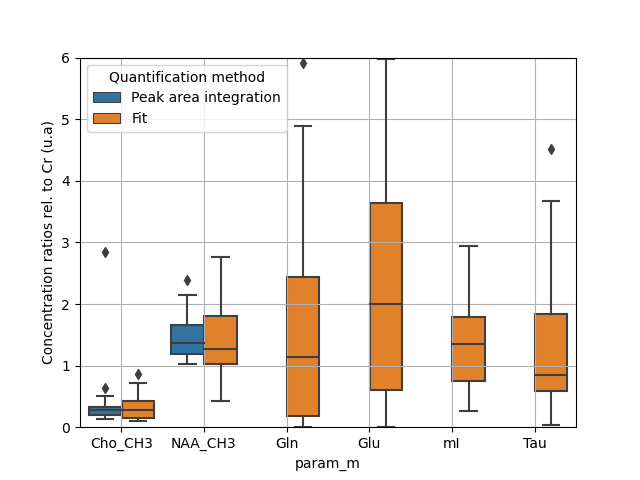

n = 15
Metabolite      	 Area (SD) 	 Fit (SD) 	 raw CRB (SD) 	 ratio CRB (SD) 	 ratio CV (%)
Cho_CH3         	 0.46 (0.68) 	 0.34 (0.23) 	 0.27 (0.53) 	 178.64 (458.19) 	 66.49
NAA_CH3         	 1.47 (0.40) 	 1.45 (0.69) 	 1.60 (3.58) 	 169.46 (427.45) 	 47.71
Gln             	 0.00 (0.00) 	 1.75 (1.89) 	 2.34 (5.52) 	 916.97 (2086.14) 	 108.03
Glu             	 0.00 (0.00) 	 2.98 (3.46) 	 3.15 (10.21) 	 1125.94 (2873.63) 	 116.26
mI              	 0.00 (0.00) 	 1.32 (0.78) 	 1.88 (4.38) 	 464.96 (1544.88) 	 58.81
Tau             	 0.00 (0.00) 	 1.35 (1.35) 	 3.32 (8.35) 	 327.76 (955.69) 	 100.03


In [40]:
df = df_sc

# keep only subjects with 2 studies
df_ths
df_p1 = 

df_filtered = df.loc[   (df["study"] == 1) &
                        (df["study"] == 2) &
                        (df["dataset_snr_final"] > 5) &
                        (df["dataset_lw"] < 50)  ]

metabolites_to_hide_list = ["Cho_CH2",
                            "Cr_CH3",
                            "Cr_CH2",
                            "NAA_CH2", "Lip1", "Lip2", "Water"]

params_to_show_list = ['params_area_pnorm_T2norm_ratio_cre_obj', 'params_fit_T2norm_ratio_cre_obj']

# remove Pelayo because no REF scan, fucking up abs estimations!
psid_to_hide_list = ["300_1"]

this_df = df_filtered.loc[(df_filtered["param_p"] == "cm") &
                            (df_filtered["param_p_type"] == "params_area_pnorm_T2norm_ratio_cre_obj") & 
                            (df_filtered["param_p_val_type"] == "val") &
                            (df_filtered["param_m"].isin(["Cho_CH3", "NAA_CH3"]))
                            ]

this_df2 = df_filtered.loc[(df_filtered["param_p"] == "cm") &
                    (df_filtered["param_p_type"] == "params_fit_T2norm_ratio_cre_obj") & 
                    (df_filtered["param_p_val_type"] == "val") &
                    ~(df_filtered["param_m"].isin(metabolites_to_hide_list))]

this_df = this_df.append(this_df2)
this_df["param_p_type"] = this_df["param_p_type"].str.replace("params_area_pnorm_T2norm_ratio_cre_obj", "Peak area integration")
this_df["param_p_type"] = this_df["param_p_type"].str.replace("params_fit_T2norm_ratio_cre_obj", "Fit")
this_df = this_df.rename(columns = {'param_p_type':'Quantification method'})

plt.figure()
g = sns.boxplot(x="param_m", y="param_val", hue="Quantification method", data=this_df)
plt.ylabel("Concentration ratios rel. to Cr (u.a)")
plt.grid('on')
plt.ylim([0, 6])

# txt output
print("n = %d" % len(df_filtered["patient_study_id"].unique()))

print("Metabolite".ljust(15) + " \t Area (SD) \t Fit (SD) \t raw CRB (SD) \t ratio CRB (SD) \t ratio CV (%)")
for m in ["Cho_CH3", "NAA_CH3", "Gln", "Glu", "mI", "Tau"]:
    
    this_df_area = df_filtered.loc[(df_filtered["param_m"] == m) &
                     (df_filtered["param_p"] == "cm") &
                     (df_filtered["param_p_type"] == "params_area_pnorm_T2norm_ratio_cre_obj") & 
                     (df_filtered["param_p_val_type"] == "val")]
    
    this_df_fit_ratio = df_filtered.loc[(df_filtered["param_m"] == m) &
                     (df_filtered["param_p"] == "cm") &
                     (df_filtered["param_p_type"] == "params_fit_T2norm_ratio_cre_obj_with_err_prct") & 
                     (df_filtered["param_p_val_type"] == "val")]
    
    this_df_fit_raw_err = df_filtered.loc[(df_filtered["param_m"] == m) &
                     (df_filtered["param_p"] == "cm") &
                     (df_filtered["param_p_type"] == "params_fit_obj") & 
                     (df_filtered["param_p_val_type"] == "err")]  
    
    this_df_fit_ratio_err = df_filtered.loc[(df["param_m"] == m) &
                     (df_filtered["param_p"] == "cm") &
                     (df_filtered["param_p_type"] == "params_fit_T2norm_ratio_cre_obj_with_err_prct") & 
                     (df_filtered["param_p_val_type"] == "err")]  
    
    
    print("%s \t %.2f (%.2f) \t %.2f (%.2f) \t %.2f (%.2f) \t %.2f (%.2f) \t %.2f" % 
          (m.ljust(15),
           this_df_area["param_val"].mean(),
           this_df_area["param_val"].std(),
           this_df_fit_ratio["param_val"].mean(),
           this_df_fit_ratio["param_val"].std(),
           this_df_fit_raw_err["param_val"].mean(),
           this_df_fit_raw_err["param_val"].std(),
           this_df_fit_ratio_err["param_val"].mean(),
           this_df_fit_ratio_err["param_val"].std(),
           this_df_fit_ratio["param_val"].std() / this_df_fit_ratio["param_val"].mean() * 100.0 ))


# Some more questions

* Choosing SNR/LW threshold

* Percentage of exploitable scans/patients

* Water LW looks visually good in SC compared to brain right? So why is the data so different? Metabolite concentrations?

* check for intra-subject repro if any data

* What does CRB errors depend on? scatter plots CRBS(met) = f(SNR, FWHM)
    * Use this to choose which metabolites to include, how many NA are really needed

* CRBs: relative / absolute? work according to the last quantification review!

* Percentage of acceptable or quantifiable MR spectra?

* Try chord diagram


# Correlation matrix analysis
In case I missed something interesting!

## Generate a correlation matrix of all parameters
To find any correlations between any parameters

In [ ]:
df = df_sc

# correlate only numeric fields
df_num = df.select_dtypes(include=np.number)
df_corr = df_num.corr(min_periods=5).abs()

df_corr = df_corr["dataset_snr_final"]
df_corr = df_corr.loc[df_corr < (1.00 - 1e-6)]
df_corr = df_corr.loc[df_corr > 0.50]
df_corr = df_corr.sort_values(ascending=False)
df_corr

## Plot manually some findings
Choose from the following, according to correlation coeff:
* Could not find any interesting corr for SNR except with other snr estimations, fit criterias and data rejection bounds
* BMI and BFP are connected to data rejection (chemical shift, phase bounds), effective acq time, vref, tr, shims 3 & 4, exc pulse durations, f0
* LW maybe connected to noise level, phase rejection bound, shim3, shim6, weight, voi size, shim1, tr, f0, heart, height, pulse dur, vref, r, n
* Vref connected to tr, pulse dur, posY, patient weight/height
* TE is linked to pulse dur, n
* FQN, RSQs are linked to rejection bounds, snr, vref

with a R threshold of 0.5

In [ ]:
# list pairs of keys to plot correlation
interesting_corrs = {}
interesting_corrs["dataset_snr_final"] = ["dataset_raw_data__data_rejection[0]_Rejection bounds_amplitude (%)",
                                          "dataset_raw_data__data_rejection[0]_Rejection bounds_chemical shift (ppm)",
                                          "dataset_raw_data__data_rejection[0]_Rejection bounds_linewidth (Hz)[1]",
                                          "dataset_raw_data__data_rejection[0]_Rejection bounds_phase std. factor (%)",
                                         "dataset_prerej_amplitude_mean",
"dataset_prerej_linewidth_mean",
"dataset_prerej_chemical_shift_mean",
"dataset_prerej_phase_mean",
"dataset_prerej_amplitude_std",
"dataset_prerej_linewidth_std",
"dataset_prerej_chemical_shift_std",
"dataset_prerej_phase_std"]

interesting_corrs["dataset_patient_bmi"] = ["dataset_raw_data__data_rejection[0]_Rejection bounds_amplitude (%)",
                                            "dataset_raw_data__data_rejection[0]_Rejection bounds_chemical shift (ppm)",
                                            "dataset_raw_data__data_rejection[0]_Rejection bounds_linewidth (Hz)[1]",
                                            "dataset_raw_data__data_rejection[0]_Rejection bounds_phase std. factor (%)",
                                            "dataset_raw_data__sequence_eff_acquisition_time",
                                            "dataset_raw_data__sequence_vref",
                                            "dataset_raw_data__sequence_tr",
                                            "dataset_raw_data__sequence_shims[0]",
                                            "dataset_raw_data__sequence_shims[1]",
                                            "dataset_raw_data__sequence_shims[2]",
                                            "dataset_raw_data__sequence_shims[3]",
                                            "dataset_raw_data__sequence_shims[4]",
                                            "dataset_raw_data__sequence_shims[5]",
                                            "dataset_raw_data__sequence_shims[6]",
                                            "dataset_raw_data__sequence_shims[7]",
                                            "dataset_raw_data__sequence_pulse_exc_duration",
                                            "dataset_raw_data__sequence_f0",
"dataset_prerej_linewidth_mean",
"dataset_prerej_chemical_shift_mean",
"dataset_prerej_phase_mean",
"dataset_prerej_amplitude_std",
"dataset_prerej_linewidth_std",
"dataset_prerej_chemical_shift_std",
"dataset_prerej_phase_std"]

interesting_corrs["dataset_patient_bfp"] = ["dataset_raw_data__data_rejection[0]_Rejection bounds_amplitude (%)",
                                            "dataset_raw_data__data_rejection[0]_Rejection bounds_chemical shift (ppm)",
                                            "dataset_raw_data__data_rejection[0]_Rejection bounds_linewidth (Hz)[1]",
                                            "dataset_raw_data__data_rejection[0]_Rejection bounds_phase std. factor (%)",
                                            "dataset_raw_data__sequence_eff_acquisition_time",
                                            "dataset_raw_data__sequence_vref",
                                            "dataset_raw_data__sequence_tr",
                                            "dataset_raw_data__sequence_shims[0]",
                                            "dataset_raw_data__sequence_shims[1]",
                                            "dataset_raw_data__sequence_shims[2]",
                                            "dataset_raw_data__sequence_shims[3]",
                                            "dataset_raw_data__sequence_shims[4]",
                                            "dataset_raw_data__sequence_shims[5]",
                                            "dataset_raw_data__sequence_shims[6]",
                                            "dataset_raw_data__sequence_shims[7]",
                                            "dataset_raw_data__sequence_pulse_exc_duration",
                                            "dataset_raw_data__sequence_f0",
"dataset_prerej_linewidth_mean",
"dataset_prerej_chemical_shift_mean",
"dataset_prerej_phase_mean",
"dataset_prerej_amplitude_std",
"dataset_prerej_linewidth_std",
"dataset_prerej_chemical_shift_std",
"dataset_prerej_phase_std"]

interesting_corrs["dataset_lw"] = ["dataset_raw_data__noise_level",
                                   "dataset_raw_data__data_rejection[0]_Rejection bounds_amplitude (%)",
                                            "dataset_raw_data__data_rejection[0]_Rejection bounds_chemical shift (ppm)",
                                            "dataset_raw_data__data_rejection[0]_Rejection bounds_linewidth (Hz)[1]",
                                            "dataset_raw_data__data_rejection[0]_Rejection bounds_phase std. factor (%)",
                                            "dataset_raw_data__sequence_eff_acquisition_time",
                                            "dataset_raw_data__sequence_vref",
                                            "dataset_raw_data__sequence_tr",
                                            "dataset_raw_data__sequence_shims[0]",
                                            "dataset_raw_data__sequence_shims[1]",
                                            "dataset_raw_data__sequence_shims[2]",
                                            "dataset_raw_data__sequence_shims[3]",
                                            "dataset_raw_data__sequence_shims[4]",
                                            "dataset_raw_data__sequence_shims[5]",
                                            "dataset_raw_data__sequence_shims[6]",
                                            "dataset_raw_data__sequence_shims[7]",
                                            "dataset_raw_data__sequence_pulse_exc_duration",
                                            "dataset_raw_data__sequence_f0",
                                            "dataset_raw_data__patient_weight",
                                            "dataset_voxel_vol_cm3",
                                            #"dataset_heart_bpm",
                                            "dataset_raw_data__patient_height",
                                            "dataset_raw_data__sequence_pulse_rfc_duration",
                                            "dataset_raw_data__sequence_pulse_rfc_r",
                                            "dataset_raw_data__sequence_pulse_rfc_n",
"dataset_prerej_linewidth_mean",
"dataset_prerej_chemical_shift_mean",
"dataset_prerej_phase_mean",
"dataset_prerej_amplitude_std",
"dataset_prerej_linewidth_std",
"dataset_prerej_chemical_shift_std",
"dataset_prerej_phase_std"]


interesting_corrs["dataset_raw_data__sequence_vref"] = ["dataset_raw_data__sequence_tr",
                                            "dataset_raw_data__patient_weight",
                                            "dataset_raw_data__patient_height",
                                            "dataset_raw_data__sequence_pulse_exc_duration",
                                            "dataset_raw_data__sequence_pulse_rfc_duration",
                                                       "dataset_raw_data_posY_mm"]


interesting_corrs["dataset_raw_data__sequence_te"] = ["dataset_raw_data__sequence_pulse_exc_duration",
                                            "dataset_raw_data__sequence_pulse_rfc_duration",
                                                       "dataset_raw_data__sequence_pulse_rfc_n"]

# now plot all this stuff
for p1, p2_list in interesting_corrs.items():
    for p2 in p2_list:

        this_df_num = df_num.loc[ ~np.isnan(df_num[p1])
                                & ~np.isinf(df_num[p1])
                                & ~np.isnan(df_num[p2])
                                & ~np.isinf(df_num[p2])]

        rrr = this_df_num[p1].corr(this_df_num[p2])
        if(np.abs(rrr) > 0.5):
            print("p1 = %s | p2 = %s" % (p1, p2))
            x = df[p1].astype(np.float)
            y = df[p2].astype(np.float)
            g = sns.JointGrid(x=x, y=y)
            g.plot_joint(sns.regplot)
            # g.plot_marginals(sns.histplot, kde=True)
            print("R = %.2f" % x.corr(y))
